In [53]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
from glob import *

In [54]:
P = cvxopt.matrix(np.array([[1,0],[0,0]]),tc='d')
q = cvxopt.matrix(np.array([3,4]),tc='d')
g = cvxopt.matrix(np.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]),tc='d')
h = cvxopt.matrix(np.array([0,0,-15,100,80]),tc='d')

In [4]:
sol = cvxopt.solvers.qp(P,q,g,h)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  1e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  6e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  8e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  6e-17  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  3e-16  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  6e-17  7e-17
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  9e-17
 8:  2.0000e+01  2.0000e+01  9e-06  2e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]



In [5]:
print(sol['x'][0])

7.131816408857333e-07


In [6]:
P = (2.0)*cvxopt.matrix(np.array([[2, 0.5],[0.5, 1]]), tc='d')
q = cvxopt.matrix(np.array([1,1]), tc='d')
G = cvxopt.matrix(np.array([[-1.0, 0.0],[0.0, -1.0]]), tc='d')
h = cvxopt.matrix(np.array([0,0]), tc='d')
A = cvxopt.matrix(np.array([1.0, 1.0]).reshape((1,2)), tc='d')
b = cvxopt.matrix(np.array([1.0]),tc='d')

In [7]:
sol = cvxopt.solvers.qp(P,q,G,h,A,b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  1e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



In [8]:
print(sol['x'][0])
print(sol['x'][1])

0.2500000952702475
0.7499999047297524


In [77]:

def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = './plots_temp'  #./plots_temp_holo_wheel"
    frames = [] 
    for f in range(0 + 1, 1 + final):
#         print(f)
        frame = cv2.imread(f"{location}/{f}.png")
#         print(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)
        if f == final:
            for endingFrame in range(5):
                frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

In [80]:
t_del = 1
v_init = np.array([10,10])

class MPC_Agent:
    def __init__(self, start, goal, steps, vmax):
        self.xpath = []
        self.ypath = []
        self.time = 0
        self.pos = start
        self.goal = goal
        self.v = v_init
        self.steps = steps
        self.vmax = vmax
        
    def traj_opti(self):
        print("start Vx: ", self.v[0], "start Vy: ", self.v[1])
       
        x = (t_del ** 2) * np.vstack((np.hstack((np.ones((self.steps, self.steps)), np.zeros((self.steps, self.steps)))), np.hstack((np.zeros((self.steps, self.steps)), np.ones((self.steps, self.steps))))))
        P= float(2) * cvxopt.matrix(x, tc = 'd')
        kx = self.pos[0] - self.goal[0]
        ky = self.pos[1] - self.goal[1]
        Q_mat_x = float(kx) * np.ones((self.steps,1))
        Q_mat_y = float(ky) * np.ones((self.steps,1))
        Q_mat = float(2.0 * t_del) * np.vstack((Q_mat_x, Q_mat_y))
        Q = cvxopt.matrix(Q_mat, tc = 'd')
        G_mat_x = np.zeros((4 * self.steps, 2 * self.steps))
        for i in range(0, self.steps):
            G_mat_x[i][i] = -1
            G_mat_x[i + self.steps][i] = 1
            G_mat_x[i + 2*self.steps][i+self.steps] = -1
            G_mat_x[i + 3*self.steps][i+self.steps] = 1
        H_mat_x = np.zeros((4 * self.steps, 1))
        for i in range(0, self.steps):
            H_mat_x[i] = 0
            H_mat_x[i + self.steps] = self.vmax
            H_mat_x[i + 2*self.steps] = 0
            H_mat_x[i + 3*self.steps] = self.vmax
        G = cvxopt.matrix(G_mat_x, tc = 'd')
        H = cvxopt.matrix(H_mat_x, tc = 'd')
        sol = cvxopt.solvers.qp(P,Q,G,H,options={'show_progress': False})
        
        if os.path.isdir("./plots_temp"):
            shutil.rmtree("./plots_temp")
        os.mkdir("./plots_temp")  
    
        for i in range(0,self.steps):
            x_i = self.pos[0] + sol['x'][i] * t_del
            y_i = self.pos[1] + sol['x'][i + self.steps] * t_del
            
            #print(sol['x'])
            
            print(sol['x'][i])
            print(sol['x'][i + self.steps])
            self.xpath.append(x_i.astype('float'))
            self.ypath.append(y_i.astype('float'))
            self.pos[0] = x_i
            self.pos[1] = y_i
#             print(self.pos[0], self.pos[1])
            print('----------------------------------------------')
            self.time += 1
            print(self.time, self.pos[0], self.pos[1])
            self.visualize_traj() 
        frames_to_video("./plots_temp/*.png", "./Quadratic-programming-control.mp4", 10)
    
    def visualize_traj(self):
        plt.plot(self.pos[0], self.pos[1], '^',color = 'orangered', markersize = 20)
        plt.plot(self.goal[0], self.goal[1], '^',color = 'lawngreen', markersize = 20)
        plt.title("Timestamp " + str(self.time), fontsize = 20, color = 'green')
        x_path = np.array(self.xpath)
        y_path = np.array(self.ypath)
        plt.plot(x_path, y_path, color = 'gold')
#         plt.axis('off')
        plt.xticks(x_path, " ")
        plt.yticks(y_path, " ")
        plt.savefig("./plots_temp/" + str(self.time) + ".png")

        plt.show()

start Vx:  10 start Vy:  10
0.7000001490412333
1.2000000457653188
----------------------------------------------
1 1.7000001490412333 2.200000045765319


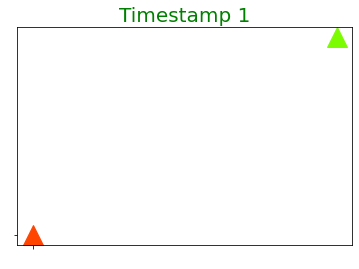

0.7000001490494766
1.2000000457653093
----------------------------------------------
2 2.40000029809071 3.400000091530628


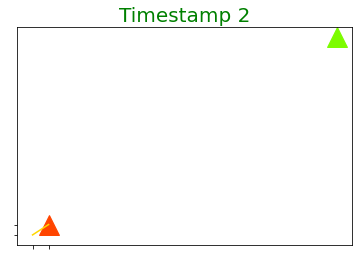

0.7000001490412328
1.2000000457653204
----------------------------------------------
3 3.1000004471319427 4.6000001372959485


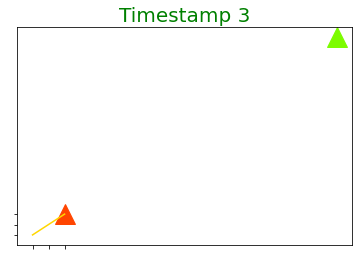

0.7000001490412312
1.2000000458566538
----------------------------------------------
4 3.8000005961731738 5.800000183152602


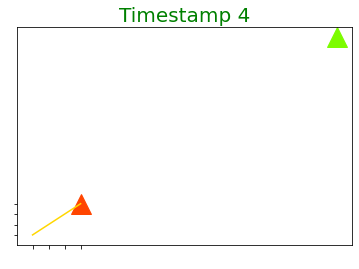

0.7000001490493081
1.200000045947089
----------------------------------------------
5 4.500000745222482 7.000000229099691


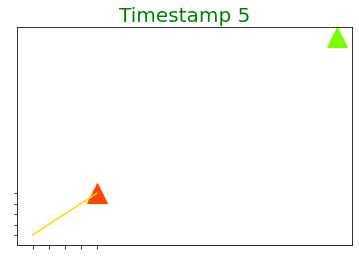

0.7000001490493102
1.2000000459480027
----------------------------------------------
6 5.200000894271792 8.200000275047694


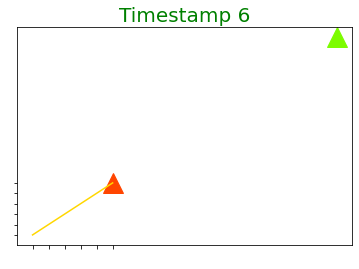

0.7000001490493079
1.2000000459480031
----------------------------------------------
7 5.9000010433211 9.400000320995698


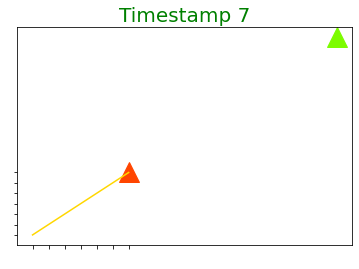

0.7000001490493098
1.2000000459480038
----------------------------------------------
8 6.60000119237041 10.600000366943702


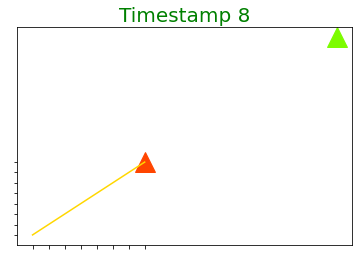

0.7000001490493923
1.2000000457643973
----------------------------------------------
9 7.300001341419803 11.8000004127081


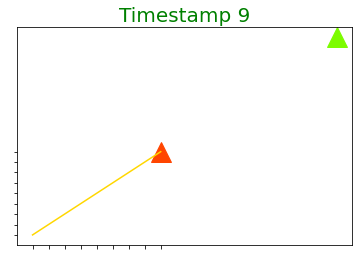

0.7000001490577198
1.2000000457653104
----------------------------------------------
10 8.000001490477523 13.00000045847341


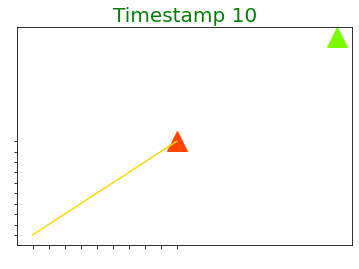

0.7000001490493929
1.200000045765311
----------------------------------------------
11 8.700001639526915 14.200000504238721


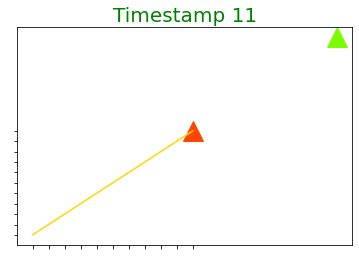

0.7000001490493928
1.2000000457653213
----------------------------------------------
12 9.400001788576308 15.400000550004043


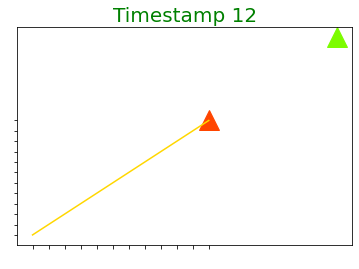

0.7000001490494749
1.2000000457653104
----------------------------------------------
13 10.100001937625782 16.60000059576935


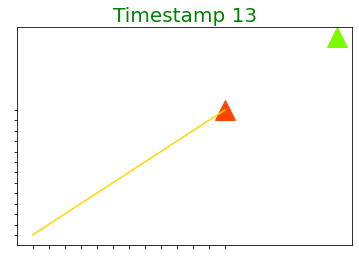

0.7000001490494748
1.2000000457653208
----------------------------------------------
14 10.800002086675256 17.800000641534673


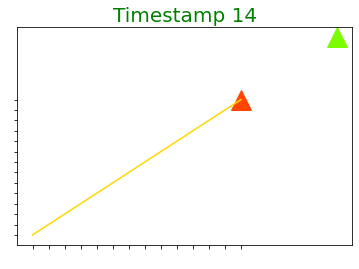

0.7000001490494738
1.200000045856667
----------------------------------------------
15 11.50000223572473 19.000000687391342


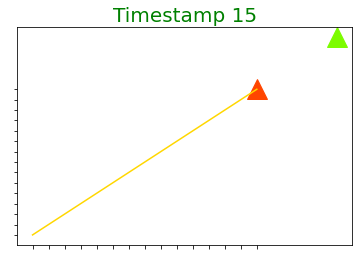

0.7000001490494749
1.2000000457653104
----------------------------------------------
16 12.200002384774205 20.200000733156653


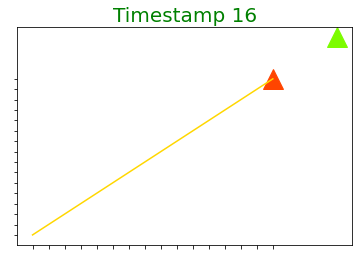

0.7000001490493927
1.2000000457653117
----------------------------------------------
17 12.900002533823598 21.400000778921964


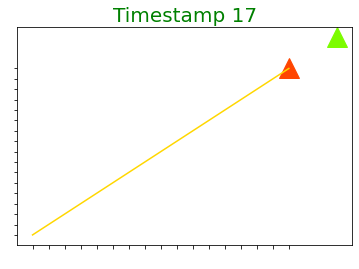

0.7000001490493921
1.2000000457653104
----------------------------------------------
18 13.60000268287299 22.600000824687275


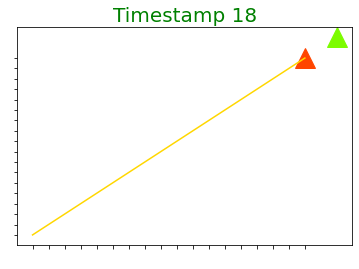

0.7000001490493921
1.2000000457653113
----------------------------------------------
19 14.300002831922383 23.800000870452585


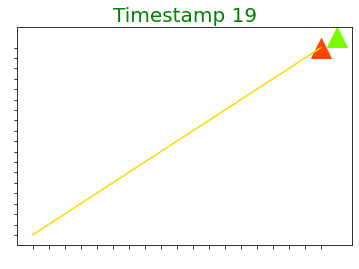

0.7000001490493926
1.2000000457653108
----------------------------------------------
20 15.000002980971775 25.000000916217896


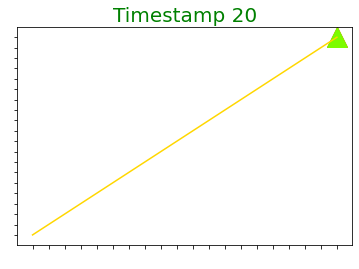

In [81]:
bot = MPC_Agent(np.array([1.0,1.0]),np.array([15.0,25.0]),20, 20.0)
bot.traj_opti()